**Name: Harish Wathore
<br>
Roll Number: 20101017
<br>**

### AE 646: SCIENTIFIC MACHINE LEARNING FOR FLUID MECHANICS

GROUP/INDIVIDUAL LSTM REVIEW EXERCISE

**EXPERIMENT WITH LSTM NEURAL NETWORK FOR 1D UNSTEADY FLOW**\
*in relation to lectures on RNN and Variants*


**STOKES 2ND PROBLEM:**\
**ONE-DIMENSIONAL UNSTEADY INCOMPRESSIBLE FLOW OVER AN OSCILLATING PLATE**

Stokes’ 1st problem deals with the unsteady flow which results when an infinitely long plate initially at rest in a quiescent fluid is suddenly set in motion in the horizontal direction at a constant velocity. A variant considered here is the Stokes’ 2nd problem in which the plate is made to oscillate in a periodic manner. The viscous fluid is kept at rest initially in a large open tank. At $t=0$, the movable base of the tank at $y(0)=0$ is imparted an oscillatory motion i.e., $u=u_o cos(2πft)$ where $f$ is the frequency of the plate oscillation and $u$ is the velocity along the horizontal direction $x$ of a Cartesisn coordinate system centered at the origin about which the plate oscillates. The motion of the plate diffuses into the interior of the quiescent fluid due to its viscosity creating a velocity profile along the $y$ direction. While the oscillating plate introduces unsteadiness, the gradients in the x direction can be assumed to be zero due to the semi-infinite nature of the medium resulting in periodicity.  The simplified 1D incompressible flow model derived from the incompressible Navier-Stokes equations by making appropriate assumptions can be easily shown to be: $u_t=\nu u_{yy}$ where $u$ is the velocity component in the horizontal $x$-direction and $\nu$ is the kinematic viscosity of the fluid. This simplified flow model can be solved analytically or numerically using a vorticity-streamfucntion formulation. Figure 1 shows the evolution of the velocity profiles $u(y,t)$ at various instants of time. The analytical solution for this problem corresponding to $u(0,t)=u_o cos⁡(2πft)$ is shown in [Stokes Problem Wikipedia Page]( https://en.wikipedia.org/wiki/Stokes_problem#:~:text=In%20fluid%20dynamics%2C%20Stokes%20problem,named%20after%20Sir%20George%20Stokes.) from which $u(y,t)$ and other pertinent properties such as the drag force on the oscillating plate can be obtained analytically.
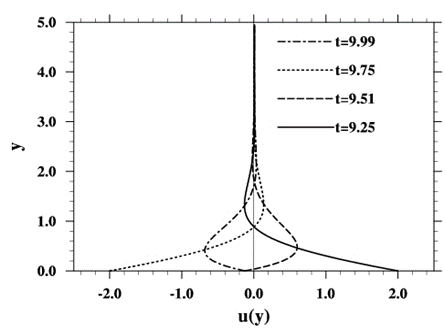
<div align="center"> 
    Fig.1: Instantaneous Velocity profiles near a periodically oscillating plate 
</div>

**COMPUTATIONAL TASKS:**

1.Use the analytic expression for the instantaneous velocity profile to generate a sequence of instantaneous velocity profiles and drag force. Train a LSTM network to predict the velocity profile and drag force at any instant of time not in the training set and then verify against the analytical solution. Note that the expressions from [Stokes Problem Wikipedia Page]( https://en.wikipedia.org/wiki/Stokes_problem#:~:text=In%20fluid%20dynamics%2C%20Stokes%20problem,named%20after%20Sir%20George%20Stokes.) are not scaled. *So think about scaling the equations and the boundary conditions first before implementing.*

2.Use a Physics Informed LSTM (LSTM-PINN) for the same problem and assess the prediction with sparse data or no data by incorporating the losses in the flow model and boundary conditions.



You may download, use and modify the LSTM code from a public domain [LSTM-RNN Tutorial with Demo](https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo#SampleStock) for this experiment. 


### Analytic Expression

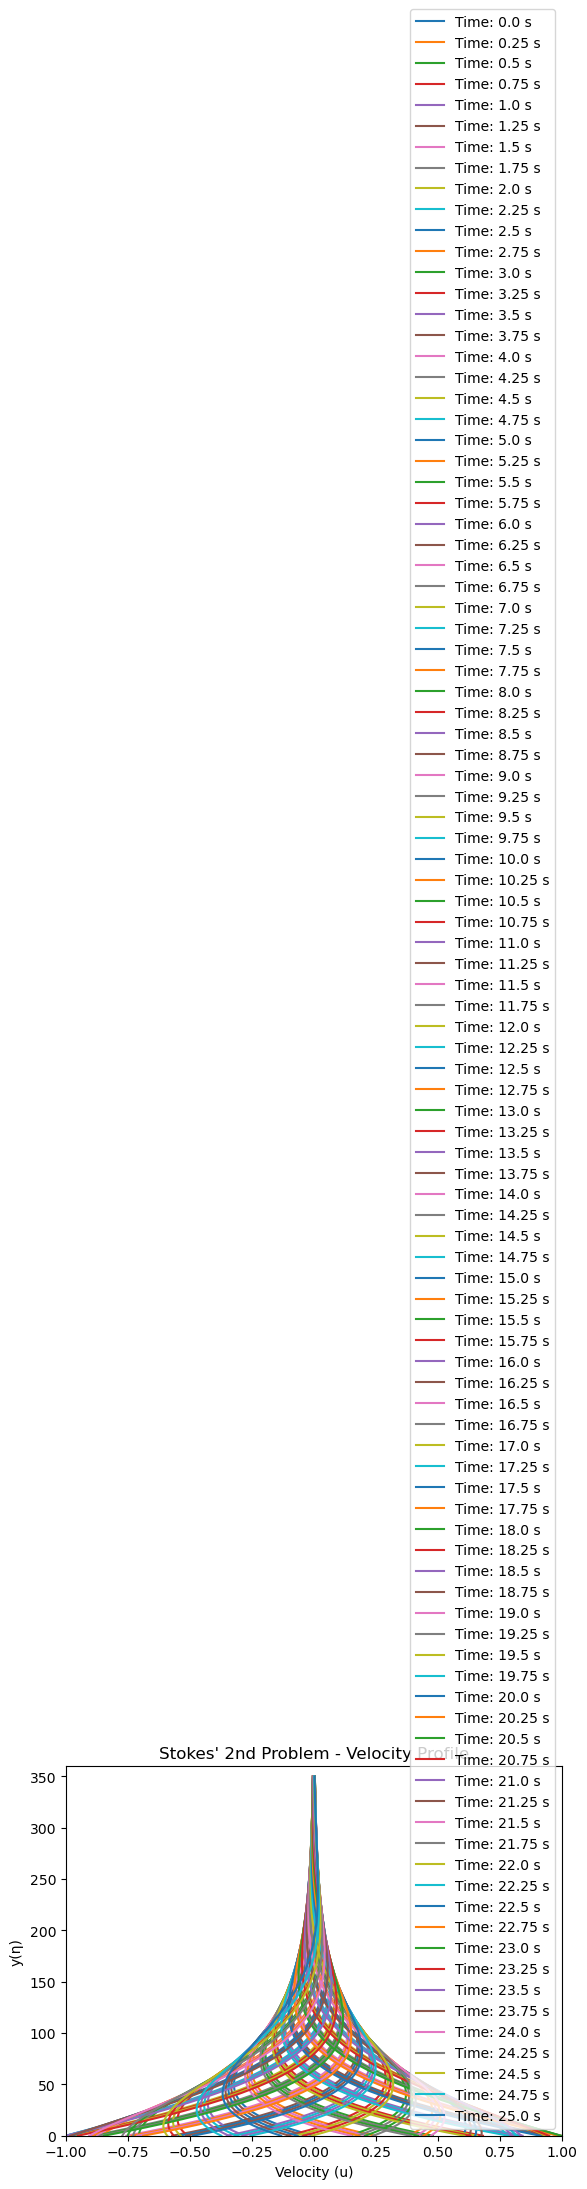

In [4]:
import numpy as np
import matplotlib.pyplot as plt

height = 350
time = 25  # total time
unot = 1
omega = 1  # angular frequency of the base
kv = 0.001  # Kinematic Viscosity
heightstep = 0.25
timestep = 0.25
y = np.arange(0, height + heightstep, heightstep)
ubar = np.copy(y)
t = np.arange(0, time + timestep, timestep)
ybar = y * np.sqrt(kv / (2 * omega))
root2 = np.sqrt(2)
tbar = omega * t

# Create empty arrays to store the results
all_u = []

for i in range(int(time / timestep) + 1):
    for j in range(int(height / heightstep) + 1):
        ubar[j] = np.exp(-ybar[j] / root2) * np.sin(tbar[i] - ybar[j] / root2)

    u = ubar * unot
    all_u.append(u)

# Convert to a NumPy array
all_u = np.array(all_u)

# Plot all time steps in a single plot
plt.figure()
for i in range(all_u.shape[0]):
    plt.plot(all_u[i], y, label=f'Time: {i * timestep} s')

plt.xlabel('Velocity (u)')
plt.ylabel('y(η)')
plt.title('Stokes\' 2nd Problem - Velocity Profile')
plt.legend()
plt.axis([-unot, unot, 0, height + 10])
plt.show()

### LSTM

In [5]:
# Creation of Data for LSTM

import numpy as np
import csv

height = 350
time = 25  # total time
unot = 1
omega = 1  # angular frequency of the base
kv = 0.001  # Kinematic Viscosity
heightstep = 0.25
timestep = 0.25
y = np.arange(0, height + heightstep, heightstep)
ubar = np.copy(y)
t = np.arange(0, time + timestep, timestep)
ybar = y * np.sqrt(kv / (2 * omega))
root2 = np.sqrt(2)
tbar = omega * t

# Create a list to store the wave data
wave_data = []

for i in range(int(time / timestep) + 1):
    for j in range(int(height / heightstep) + 1):
        ubar[j] = np.exp(-ybar[j] / root2) * np.sin(tbar[i] - ybar[j] / root2)

    u = ubar * unot

    # Store data for this time step
    time_step_data = [(t[i], y_value, u_value) for y_value, u_value in zip(y, u)]
    wave_data.append(time_step_data)

# Create a CSV file for storing the data
csv_filename = 'wave_data.csv'
with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Time', 'Y', 'U'])  # Write header

    for time_step_data in wave_data:
        csv_writer.writerows(time_step_data)

# Print a message to indicate the data has been saved
print(f"Wave data has been saved to {csv_filename}")

Wave data has been saved to wave_data.csv


In [6]:
# USING LSTM to predict data and save to new csv file

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

# Load the wave data from the CSV file
df = pd.read_csv('wave_data.csv')

# Extract the data
time_values = df['Time'].values
height_values = df['Y'].values
velocity_values = df['U'].values

# Reshape the data for LSTM input
data = np.column_stack((height_values, velocity_values))
scaler = MinMaxScaler()  # Normalize data for LSTM
data = scaler.fit_transform(data)

# Create sequences for training
sequence_length = int(0.25 / 0.25)  # Sequence length for 0.25 seconds
sequences = []
next_values = []

for i in range(len(data) - sequence_length):
    sequences.append(data[i:i + sequence_length])
    next_values.append(data[i + sequence_length])

# Convert to NumPy arrays
X = np.array(sequences)
y = np.array(next_values)

# Split data into training and testing sets (you may want to customize this)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build an LSTM model
model = keras.Sequential()
model.add(layers.LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(layers.Dense(2))  # Two output features: height and velocity
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=2, batch_size=32)

# Predict using the test data
y_pred = model.predict(X_test)

# Inverse transform to get the original scale
y_pred = scaler.inverse_transform(y_pred)

# Create a DataFrame for predictions
min_length = min(len(time_values) - split, len(height_values) - split, y_pred.shape[0])
predictions_df = pd.DataFrame({'Time': time_values[split:split+min_length], 'Y': height_values[split:split+min_length], 'U': y_pred[:min_length, 1]})


# Save predictions to a CSV file
predictions_df.to_csv('lstm_predictions.csv', index=False)

Epoch 1/2
3538/3538 [==============================] - 12s 3ms/step - loss: 0.0048
Epoch 2/2
885/885 [==============================] - 2s 2ms/step


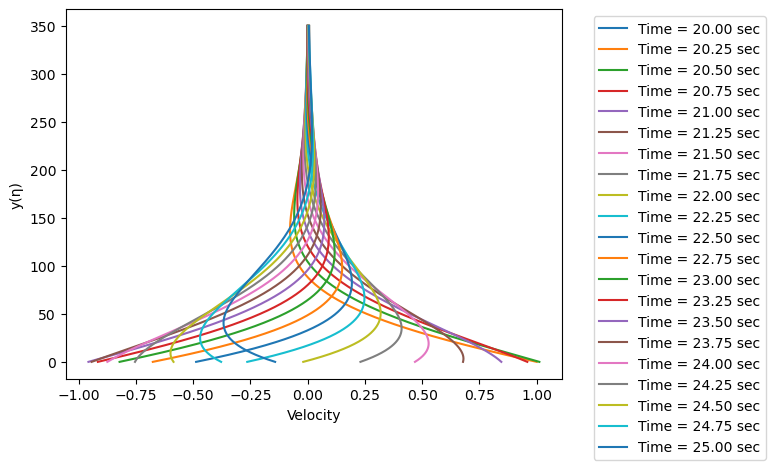

In [7]:
# PLOT the new velocity profile from predicted data

import pandas as pd
import matplotlib.pyplot as plt

# Load the LSTM predictions CSV
predictions_df = pd.read_csv('lstm_predictions.csv')

# Get unique time values
unique_times = predictions_df['Time'].unique()

# Plot height vs. velocity for every unique time value
plt.figure()
for t in unique_times:
    subset = predictions_df[predictions_df['Time'] == t]
    heights = subset['Y']
    velocities = subset['U']
    plt.plot(velocities, heights, label=f'Time = {t:.2f} sec')

plt.xlabel('Velocity')
plt.ylabel('y(η)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
